## Train line segmentation network

In [1]:
from tqdm import tqdm

In [2]:
import os.path
import time
import numpy as np
from PIL import Image
# torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
# addons
import torchvision
from torchvision import transforms as trafos
# from torchvision import models
from tensorboardX import SummaryWriter

In [3]:
#%matplotlib inline
import matplotlib.pyplot as plt

/home/tobias/.virtualenvs/pytorch/local/lib/python2.7/site-packages/matplotlib/__init__.py:907: MatplotlibDeprecationWarning: The backend.qt4 rcParam was deprecated in version 2.2.  In order to force the use of a specific Qt binding, either import that binding first, or set the QT_API environment variable.
  mplDeprecation)


In [4]:
relative_path = '../../'
# ensure that parent path is on the python path in order to have all packages available
import sys, os
parent_path = os.path.join(os.getcwd(), relative_path)
parent_path = os.path.realpath(parent_path)  # os.path.abspath(...)
sys.path.insert(0, parent_path)

In [5]:
from lib.detection.line_detection import *
from lib.evaluations.line_evaluation import *
from lib.detection.sign_detection import *

In [6]:
# mystuff
from lib.utils.bbox_utils import clip_boxes
from lib.utils.transform_utils import crop_pil_image, UnNormalize
from lib.utils.pytorch_utils import (train_model, get_tensorboard_writer, 
                                     prepare_embedding, visualize_model, weights_init)

from lib.datasets.lines_dataset import CuneiformLines
from lib.models.cuneinet import initialize_weights, LRN, CuneiNetFCN

### Config Basics

In [7]:
# lineNet
model_version = 'v002'

# config datasets for training and testing
train_data_set = 'train'  
test_data_set = 'test'  

# pretrained cuneiNet
with_pretrained = False
pretrained_version = 'v019'

# config schedule
num_epochs = 301
lr_milestones = [150, 250]

num_epochs = 101
lr_milestones = [60, 80]

In [8]:
# config data preprocess and augmentation
dataset_params = dict(batch_size=[128, 32],
                      line_height=32,  # 40
                      sample_radius=3*32,
                      expo=0.5,  # 2
                      soft_bg_frac = [0.1, 0.0], # soft('easy') background
                      crop_size=[227, 227],
                      #patch_size=[256, 256],
                      patch_size=[320, 320],
                      num_workers=3, # 0 single thread
                      num_classes=2,
                      gray_mean=[0.5],
                      gray_std=[1.0]
                     )

In [9]:
# set log file name
version_remark = 'soft_bg_10_trainEXT_rrc05_v019'

### Config Data Augmentation

In [10]:
num_classes = dataset_params['num_classes']
crop_h, crop_w = dataset_params['crop_size']
gray_mean = dataset_params['gray_mean']
gray_std = dataset_params['gray_std']
num_c = 1

In [11]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': trafos.Compose([trafos.Lambda(lambda x: x.convert('L')),
                             trafos.RandomRotation(8),
                             trafos.CenterCrop((crop_h+15, crop_w+15)),
                             trafos.RandomResizedCrop(crop_h, scale=(0.5, 1.0), 
                                                      ratio=(3./4., 4./3.), 
                                                      interpolation=Image.BILINEAR),
                             trafos.ToTensor(),
                             trafos.Normalize(mean=gray_mean * num_c, std=gray_std * num_c),              
                           ]),
    'dev': trafos.Compose([trafos.Lambda(lambda x: x.convert('L')),
                           trafos.Resize((crop_h, crop_w), interpolation=Image.BILINEAR),
                           trafos.ToTensor(),
                           trafos.Normalize(mean=gray_mean * num_c, std=gray_std * num_c),              
                           ]),
}

In [12]:
re_transform = torchvision.transforms.Compose([
    UnNormalize(mean=gray_mean, std=gray_std),
    torchvision.transforms.ToPILImage(),
                                              ])
re_transform_rgb = torchvision.transforms.Compose([
    UnNormalize(mean=gray_mean * 3, std=gray_std * 3),
    torchvision.transforms.ToPILImage(),
                                              ])

### Create Datasets and Loaders

In [13]:
# Datasets
image_datasets = {x[0]: CuneiformLines(dataset_params, transform=data_transforms[x[0]], 
                    target_transform=None, relative_path=relative_path, split=x[1])
                  for x in [['train', train_data_set], ['dev', test_data_set]]}
# Data Loaders
num_workers = [dataset_params['num_workers'], 0]
batch_size = dataset_params['batch_size']
shuffle_set = [True, False]
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size[i], shuffle=shuffle_set[i], 
                                              num_workers=num_workers[i], pin_memory=False, drop_last=True)
              for i, x in enumerate(['train', 'dev'])}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'dev']}

  0%|          | 0/38 [00:00<?, ?it/s]/home/tobias/Dropbox/NeuralNets/caffe_workspace/pycaffe/cuneiform-sign-detection/lib/datasets/lines_dataset.py:58: RuntimeWarning: invalid value encountered in sqrt
  sample_freq = (-sample_freq / sample_radius + 1) ** expo
  0%|          | 0/16 [00:00<?, ?it/s]

Setup train dataset with 410 rows and 2003 samples


100%|██████████| 16/16 [00:09<00:00,  1.71it/s]

Setup test dataset with 208 rows and 6765 samples


### Visualize Trainset Samples

In [14]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(inputs.shape, classes.shape, inputs.min(), inputs.max())

(torch.Size([128, 1, 227, 227]), torch.Size([128]), tensor(-0.5000), tensor(0.4804))


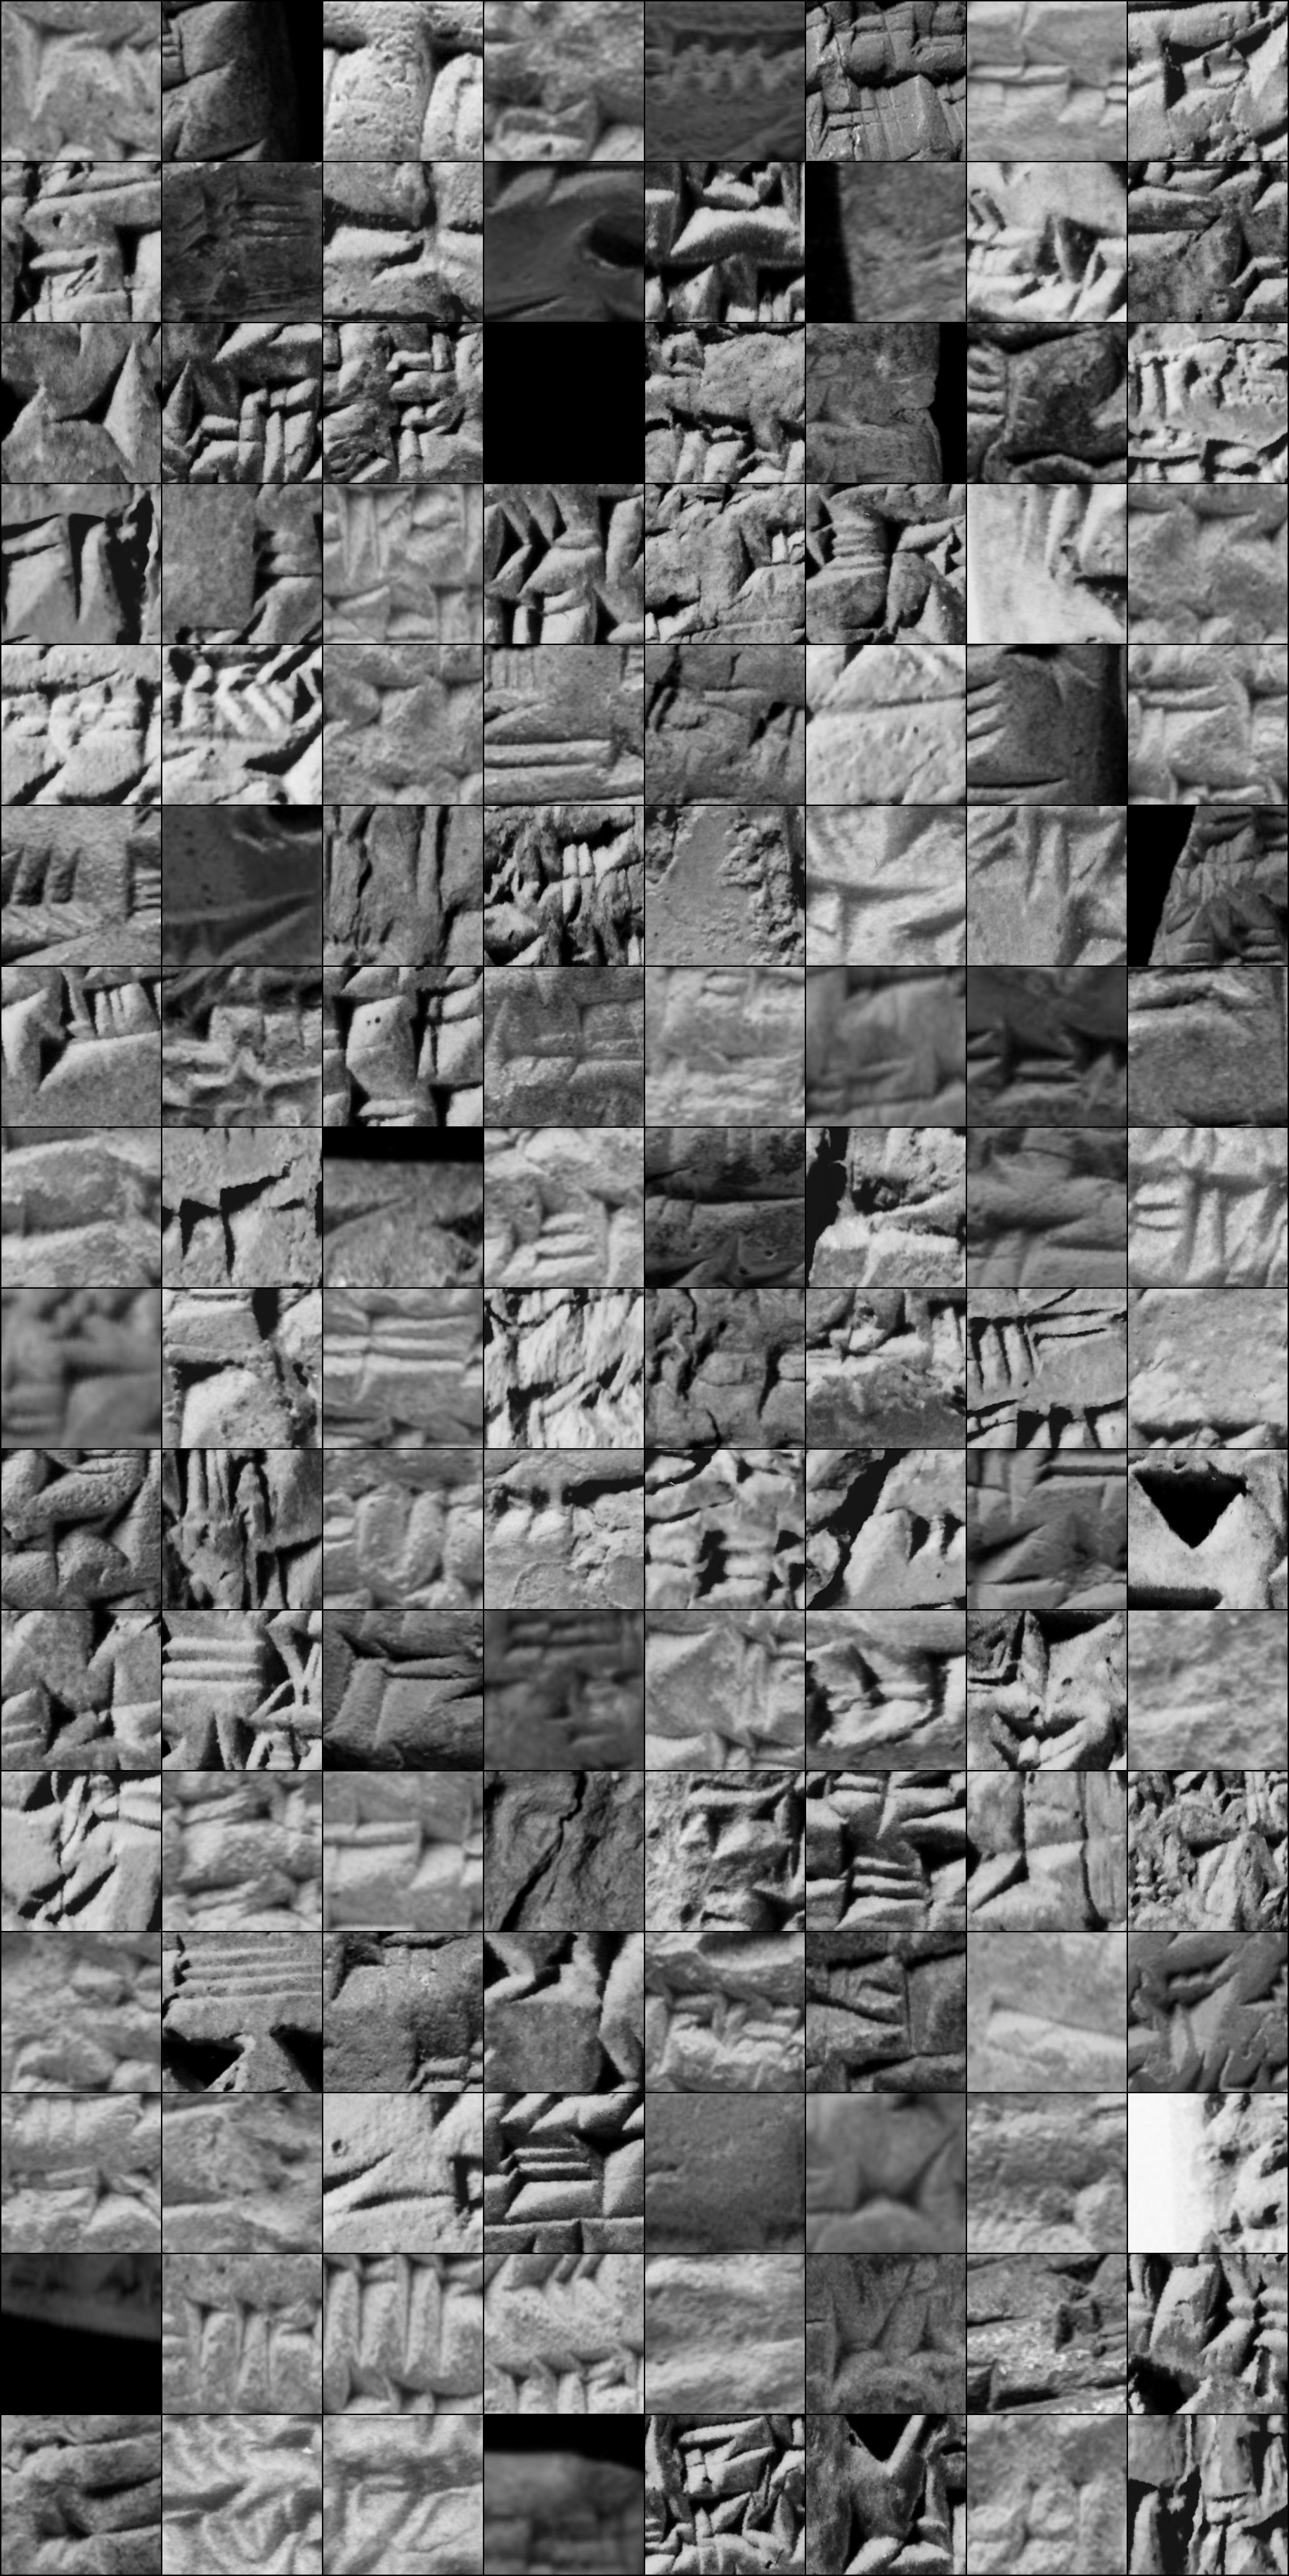

In [15]:
# Make a grid from batch [assume all images are ]
out = torchvision.utils.make_grid(inputs, pad_value=-gray_mean[0])
re_transform_rgb(out)

### Config Network

In [16]:
class LineNet(nn.Module):

    def __init__(self, num_classes=1000, input_channels=3):
        super(LineNet, self).__init__()
        
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(384, affine=False, momentum=.1)
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256, affine=False, momentum=.1)
        
        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=11, stride=4, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            LRN(alpha=1e-4, beta=0.75, local_size=1),
            nn.Conv2d(64, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            LRN(alpha=1e-4, beta=0.75, local_size=1),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384, affine=False, momentum=.1),
            nn.ReLU(inplace=True),
            self.conv4,
            self.bn4,
            nn.ReLU(inplace=True),
            self.conv5,
            self.bn5,
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.fc6 = nn.Linear(256 * 6 * 6, 512)
        self.score = nn.Linear(512, 240)
        self.classifier = nn.Sequential(
            self.fc6,
            nn.ReLU(inplace=True),
            nn.Dropout(),
            self.score,
        )
        self.line_score = nn.Linear(512, num_classes)
        self.line_classifier = nn.Sequential(
            self.fc6,
            nn.ReLU(inplace=True),
            nn.Dropout(),
            self.line_score,
        )
        initialize_weights(self)

    def legacy_forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)  # x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)  # x = x.view(x.size(0), -1)
        x = self.line_classifier(x)

        return x

In [17]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        m.weight.data.normal_(0, 0.005)
        m.bias.data.zero_()

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [19]:
# choose model filename
weights_path = '{}results/weights/lineNet_basic_{}.pth'.format(relative_path, model_version)
assert not os.path.exists(weights_path), "Filename '{}' has already been claimed!".format(weights_path)

# load model definition
model_ft = LineNet(num_classes=num_classes, input_channels=num_c)

# load weights from
if with_pretrained:
    pretrained_weights_path = '{}result/weights/cuneiNet_basic_{}.pth'.format(relative_path, pretrained_version)
    model_ft.load_state_dict(torch.load(pretrained_weights_path), strict=False)     

# deploy on device
model_ft = model_ft.to(device)

# print model
print(model_ft)

/home/tobias/.virtualenvs/pytorch/local/lib/python2.7/site-packages/torch/cuda/__init__.py:117: UserWarning: 
    Found GPU1 GeForce GTX 770 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


LineNet(
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): LRN(
      (average): AvgPool2d(kernel_size=1, stride=1, padding=0)
    )
    (4): Conv2d(64, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): LRN(
      (average): AvgPool2d(kernel_size=1, stride=1, padding=0)
    )
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e

### Config Trainer

In [20]:
criterion = nn.CrossEntropyLoss()

optimizer_warmup = optim.SGD(model_ft.line_classifier.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
lr_scheduler_warmup = lr_scheduler.StepLR(optimizer_warmup, step_size=50, gamma=0.1)

# training setup
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

# Decay LR by a factor of 0.1 every 7 epochs
#lr_scheduler_ft = lr_scheduler.StepLR(optimizer_ft, step_size=step_size, gamma=0.1)
lr_scheduler_ft = lr_scheduler.MultiStepLR(optimizer_ft, milestones=lr_milestones, gamma=0.2)

# init logger
if version_remark == '':
    comment_str = '_{}'.format(model_version)
else:
    comment_str = '_{}_{}'.format(model_version, version_remark)
writer = get_tensorboard_writer(logs_folder='{}results/run_logs/line_segmentation'.format(relative_path), 
                                comment=comment_str)

writer.add_image('train/sample_input', out, 0) # depends on re_transform_rgb(out.clone()) being called once
writer.add_text('model/definition', model_ft.__str__(), 0)

### Train Model

In [21]:
# run
model_ft = train_model(model_ft, criterion, optimizer_ft, lr_scheduler_ft, 
                       writer, dataloaders, dataset_sizes, device, num_epochs=num_epochs, test_every=10)

# Save only the model parameters
torch.save(model_ft.state_dict(), weights_path)

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch 0/100
----------
train Loss: 0.0048 Acc: 0.5991
train Number correct: 1200 


  1%|          | 1/101 [00:37<1:02:27, 37.48s/it]

dev Loss: 0.0214 Acc: 0.6105
dev Number correct: 4130 
Epoch 1/100
----------


  2%|▏         | 2/101 [00:43<35:28, 21.50s/it]  

train Loss: 0.0042 Acc: 0.6985
train Number correct: 1399 
Epoch 2/100
----------


  3%|▎         | 3/101 [00:48<26:23, 16.16s/it]

train Loss: 0.0040 Acc: 0.7009
train Number correct: 1404 
Epoch 3/100
----------


  4%|▍         | 4/101 [00:54<21:51, 13.52s/it]

train Loss: 0.0041 Acc: 0.7059
train Number correct: 1414 
Epoch 4/100
----------


  5%|▍         | 5/101 [00:58<18:51, 11.79s/it]

train Loss: 0.0038 Acc: 0.7334
train Number correct: 1469 
Epoch 5/100
----------


  6%|▌         | 6/101 [01:03<16:47, 10.61s/it]

train Loss: 0.0038 Acc: 0.7319
train Number correct: 1466 
Epoch 6/100
----------


  7%|▋         | 7/101 [01:08<15:22,  9.82s/it]

train Loss: 0.0038 Acc: 0.7319
train Number correct: 1466 
Epoch 7/100
----------


  8%|▊         | 8/101 [01:13<14:16,  9.21s/it]

train Loss: 0.0039 Acc: 0.7159
train Number correct: 1434 
Epoch 8/100
----------


  9%|▉         | 9/101 [01:18<13:19,  8.69s/it]

train Loss: 0.0037 Acc: 0.7414
train Number correct: 1485 
Epoch 9/100
----------


 10%|▉         | 10/101 [01:22<12:33,  8.28s/it]

train Loss: 0.0037 Acc: 0.7334
train Number correct: 1469 
Epoch 10/100
----------
train Loss: 0.0038 Acc: 0.7339
train Number correct: 1470 


 11%|█         | 11/101 [01:59<16:19, 10.88s/it]

dev Loss: 0.0174 Acc: 0.7123
dev Number correct: 4819 
Epoch 11/100
----------


 12%|█▏        | 12/101 [02:04<15:20, 10.34s/it]

train Loss: 0.0038 Acc: 0.7334
train Number correct: 1469 
Epoch 12/100
----------


 13%|█▎        | 13/101 [02:08<14:30,  9.89s/it]

train Loss: 0.0038 Acc: 0.7359
train Number correct: 1474 
Epoch 13/100
----------


 14%|█▍        | 14/101 [02:12<13:45,  9.49s/it]

train Loss: 0.0036 Acc: 0.7399
train Number correct: 1482 
Epoch 14/100
----------


 15%|█▍        | 15/101 [02:18<13:11,  9.21s/it]

train Loss: 0.0039 Acc: 0.7149
train Number correct: 1432 
Epoch 15/100
----------


 16%|█▌        | 16/101 [02:22<12:39,  8.93s/it]

train Loss: 0.0036 Acc: 0.7394
train Number correct: 1481 
Epoch 16/100
----------


 17%|█▋        | 17/101 [02:28<12:11,  8.71s/it]

train Loss: 0.0033 Acc: 0.7604
train Number correct: 1523 
Epoch 17/100
----------


 18%|█▊        | 18/101 [02:33<11:47,  8.52s/it]

train Loss: 0.0037 Acc: 0.7354
train Number correct: 1473 
Epoch 18/100
----------


 19%|█▉        | 19/101 [02:38<11:22,  8.32s/it]

train Loss: 0.0034 Acc: 0.7634
train Number correct: 1529 
Epoch 19/100
----------


 20%|█▉        | 20/101 [02:42<10:58,  8.13s/it]

train Loss: 0.0036 Acc: 0.7499
train Number correct: 1502 
Epoch 20/100
----------
train Loss: 0.0036 Acc: 0.7484
train Number correct: 1499 


 21%|██        | 21/101 [03:18<12:34,  9.43s/it]

dev Loss: 0.0163 Acc: 0.7335
dev Number correct: 4962 
Epoch 21/100
----------


 22%|██▏       | 22/101 [03:22<12:06,  9.20s/it]

train Loss: 0.0036 Acc: 0.7444
train Number correct: 1491 
Epoch 22/100
----------


 23%|██▎       | 23/101 [03:26<11:40,  8.98s/it]

train Loss: 0.0038 Acc: 0.7364
train Number correct: 1475 
Epoch 23/100
----------


 24%|██▍       | 24/101 [03:31<11:18,  8.81s/it]

train Loss: 0.0036 Acc: 0.7464
train Number correct: 1495 
Epoch 24/100
----------


 25%|██▍       | 25/101 [03:36<10:58,  8.66s/it]

train Loss: 0.0035 Acc: 0.7449
train Number correct: 1492 
Epoch 25/100
----------


 26%|██▌       | 26/101 [03:41<10:37,  8.50s/it]

train Loss: 0.0037 Acc: 0.7409
train Number correct: 1484 
Epoch 26/100
----------


 27%|██▋       | 27/101 [03:45<10:18,  8.36s/it]

train Loss: 0.0037 Acc: 0.7474
train Number correct: 1497 
Epoch 27/100
----------


 28%|██▊       | 28/101 [03:50<10:01,  8.25s/it]

train Loss: 0.0037 Acc: 0.7334
train Number correct: 1469 
Epoch 28/100
----------


 29%|██▊       | 29/101 [03:56<09:46,  8.14s/it]

train Loss: 0.0035 Acc: 0.7499
train Number correct: 1502 
Epoch 29/100
----------


 30%|██▉       | 30/101 [04:00<09:29,  8.03s/it]

train Loss: 0.0036 Acc: 0.7564
train Number correct: 1515 
Epoch 30/100
----------
train Loss: 0.0034 Acc: 0.7649
train Number correct: 1532 


 31%|███       | 31/101 [04:37<10:26,  8.95s/it]

dev Loss: 0.0165 Acc: 0.7357
dev Number correct: 4977 
Epoch 31/100
----------


 32%|███▏      | 32/101 [04:41<10:07,  8.81s/it]

train Loss: 0.0035 Acc: 0.7509
train Number correct: 1504 
Epoch 32/100
----------


 33%|███▎      | 33/101 [04:46<09:49,  8.67s/it]

train Loss: 0.0036 Acc: 0.7434
train Number correct: 1489 
Epoch 33/100
----------


 34%|███▎      | 34/101 [04:51<09:33,  8.56s/it]

train Loss: 0.0035 Acc: 0.7479
train Number correct: 1498 
Epoch 34/100
----------


 35%|███▍      | 35/101 [04:56<09:18,  8.46s/it]

train Loss: 0.0036 Acc: 0.7434
train Number correct: 1489 
Epoch 35/100
----------


 36%|███▌      | 36/101 [05:00<09:02,  8.35s/it]

train Loss: 0.0035 Acc: 0.7594
train Number correct: 1521 
Epoch 36/100
----------


 37%|███▋      | 37/101 [05:05<08:47,  8.25s/it]

train Loss: 0.0035 Acc: 0.7514
train Number correct: 1505 
Epoch 37/100
----------


 38%|███▊      | 38/101 [05:10<08:34,  8.16s/it]

train Loss: 0.0035 Acc: 0.7584
train Number correct: 1519 
Epoch 38/100
----------


 39%|███▊      | 39/101 [05:15<08:21,  8.08s/it]

train Loss: 0.0037 Acc: 0.7379
train Number correct: 1478 
Epoch 39/100
----------


 40%|███▉      | 40/101 [05:19<08:07,  8.00s/it]

train Loss: 0.0036 Acc: 0.7479
train Number correct: 1498 
Epoch 40/100
----------
train Loss: 0.0036 Acc: 0.7454
train Number correct: 1493 


 41%|████      | 41/101 [05:57<08:43,  8.72s/it]

dev Loss: 0.0156 Acc: 0.7608
dev Number correct: 5147 
Epoch 41/100
----------


 42%|████▏     | 42/101 [06:02<08:28,  8.62s/it]

train Loss: 0.0034 Acc: 0.7574
train Number correct: 1517 
Epoch 42/100
----------


 43%|████▎     | 43/101 [06:07<08:15,  8.54s/it]

train Loss: 0.0035 Acc: 0.7614
train Number correct: 1525 
Epoch 43/100
----------


 44%|████▎     | 44/101 [06:11<08:01,  8.44s/it]

train Loss: 0.0033 Acc: 0.7569
train Number correct: 1516 
Epoch 44/100
----------


 45%|████▍     | 45/101 [06:16<07:48,  8.36s/it]

train Loss: 0.0035 Acc: 0.7559
train Number correct: 1514 
Epoch 45/100
----------


 46%|████▌     | 46/101 [06:21<07:36,  8.29s/it]

train Loss: 0.0037 Acc: 0.7429
train Number correct: 1488 
Epoch 46/100
----------


 47%|████▋     | 47/101 [06:26<07:24,  8.22s/it]

train Loss: 0.0035 Acc: 0.7564
train Number correct: 1515 
Epoch 47/100
----------


 48%|████▊     | 48/101 [06:31<07:12,  8.15s/it]

train Loss: 0.0035 Acc: 0.7644
train Number correct: 1531 
Epoch 48/100
----------


 49%|████▊     | 49/101 [06:36<07:00,  8.09s/it]

train Loss: 0.0034 Acc: 0.7748
train Number correct: 1552 
Epoch 49/100
----------


 50%|████▉     | 50/101 [06:41<06:49,  8.03s/it]

train Loss: 0.0035 Acc: 0.7614
train Number correct: 1525 
Epoch 50/100
----------
train Loss: 0.0035 Acc: 0.7474
train Number correct: 1497 


 50%|█████     | 51/101 [07:18<07:09,  8.60s/it]

dev Loss: 0.0170 Acc: 0.7288
dev Number correct: 4930 
Epoch 51/100
----------


 51%|█████▏    | 52/101 [07:23<06:58,  8.53s/it]

train Loss: 0.0036 Acc: 0.7609
train Number correct: 1524 
Epoch 52/100
----------


 52%|█████▏    | 53/101 [07:28<06:45,  8.45s/it]

train Loss: 0.0036 Acc: 0.7494
train Number correct: 1501 
Epoch 53/100
----------


 53%|█████▎    | 54/101 [07:32<06:33,  8.38s/it]

train Loss: 0.0035 Acc: 0.7569
train Number correct: 1516 
Epoch 54/100
----------


 54%|█████▍    | 55/101 [07:37<06:22,  8.32s/it]

train Loss: 0.0036 Acc: 0.7524
train Number correct: 1507 
Epoch 55/100
----------


 55%|█████▌    | 56/101 [07:42<06:11,  8.26s/it]

train Loss: 0.0035 Acc: 0.7549
train Number correct: 1512 
Epoch 56/100
----------


 56%|█████▋    | 57/101 [07:47<06:00,  8.20s/it]

train Loss: 0.0036 Acc: 0.7604
train Number correct: 1523 
Epoch 57/100
----------


 57%|█████▋    | 58/101 [07:52<05:49,  8.14s/it]

train Loss: 0.0035 Acc: 0.7584
train Number correct: 1519 
Epoch 58/100
----------


 58%|█████▊    | 59/101 [07:56<05:39,  8.08s/it]

train Loss: 0.0036 Acc: 0.7469
train Number correct: 1496 
Epoch 59/100
----------


 59%|█████▉    | 60/101 [08:01<05:28,  8.02s/it]

train Loss: 0.0034 Acc: 0.7644
train Number correct: 1531 
Epoch 60/100
----------
train Loss: 0.0035 Acc: 0.7574
train Number correct: 1517 


 60%|██████    | 61/101 [08:38<05:40,  8.50s/it]

dev Loss: 0.0160 Acc: 0.7449
dev Number correct: 5039 
Epoch 61/100
----------


 61%|██████▏   | 62/101 [08:43<05:29,  8.44s/it]

train Loss: 0.0035 Acc: 0.7484
train Number correct: 1499 
Epoch 62/100
----------


 62%|██████▏   | 63/101 [08:47<05:18,  8.38s/it]

train Loss: 0.0034 Acc: 0.7609
train Number correct: 1524 
Epoch 63/100
----------


 63%|██████▎   | 64/101 [08:52<05:07,  8.32s/it]

train Loss: 0.0035 Acc: 0.7469
train Number correct: 1496 
Epoch 64/100
----------


 64%|██████▍   | 65/101 [08:57<04:57,  8.26s/it]

train Loss: 0.0033 Acc: 0.7683
train Number correct: 1539 
Epoch 65/100
----------


 65%|██████▌   | 66/101 [09:02<04:47,  8.22s/it]

train Loss: 0.0034 Acc: 0.7559
train Number correct: 1514 
Epoch 66/100
----------


 66%|██████▋   | 67/101 [09:07<04:37,  8.17s/it]

train Loss: 0.0033 Acc: 0.7723
train Number correct: 1547 
Epoch 67/100
----------


 67%|██████▋   | 68/101 [09:11<04:27,  8.12s/it]

train Loss: 0.0032 Acc: 0.7708
train Number correct: 1544 
Epoch 68/100
----------


 68%|██████▊   | 69/101 [09:16<04:18,  8.07s/it]

train Loss: 0.0033 Acc: 0.7683
train Number correct: 1539 
Epoch 69/100
----------


 69%|██████▉   | 70/101 [09:21<04:08,  8.02s/it]

train Loss: 0.0034 Acc: 0.7589
train Number correct: 1520 
Epoch 70/100
----------
train Loss: 0.0033 Acc: 0.7644
train Number correct: 1531 


 70%|███████   | 71/101 [09:58<04:13,  8.44s/it]

dev Loss: 0.0154 Acc: 0.7592
dev Number correct: 5136 
Epoch 71/100
----------


 71%|███████▏  | 72/101 [10:04<04:03,  8.39s/it]

train Loss: 0.0034 Acc: 0.7559
train Number correct: 1514 
Epoch 72/100
----------


 72%|███████▏  | 73/101 [10:08<03:53,  8.34s/it]

train Loss: 0.0033 Acc: 0.7698
train Number correct: 1542 
Epoch 73/100
----------


 73%|███████▎  | 74/101 [10:14<03:44,  8.30s/it]

train Loss: 0.0033 Acc: 0.7758
train Number correct: 1554 
Epoch 74/100
----------


 74%|███████▍  | 75/101 [10:19<03:34,  8.26s/it]

train Loss: 0.0033 Acc: 0.7644
train Number correct: 1531 
Epoch 75/100
----------


 75%|███████▌  | 76/101 [10:24<03:25,  8.22s/it]

train Loss: 0.0032 Acc: 0.7683
train Number correct: 1539 
Epoch 76/100
----------


 76%|███████▌  | 77/101 [10:28<03:16,  8.17s/it]

train Loss: 0.0033 Acc: 0.7639
train Number correct: 1530 
Epoch 77/100
----------


 77%|███████▋  | 78/101 [10:33<03:06,  8.13s/it]

train Loss: 0.0031 Acc: 0.7813
train Number correct: 1565 
Epoch 78/100
----------


 78%|███████▊  | 79/101 [10:38<02:57,  8.09s/it]

train Loss: 0.0032 Acc: 0.7798
train Number correct: 1562 
Epoch 79/100
----------


 79%|███████▉  | 80/101 [10:43<02:49,  8.05s/it]

train Loss: 0.0032 Acc: 0.7868
train Number correct: 1576 
Epoch 80/100
----------
train Loss: 0.0031 Acc: 0.7768
train Number correct: 1556 


 80%|████████  | 81/101 [11:20<02:48,  8.41s/it]

dev Loss: 0.0148 Acc: 0.7727
dev Number correct: 5227 
Epoch 81/100
----------


 81%|████████  | 82/101 [11:26<02:39,  8.37s/it]

train Loss: 0.0031 Acc: 0.7748
train Number correct: 1552 
Epoch 82/100
----------


 82%|████████▏ | 83/101 [11:31<02:29,  8.33s/it]

train Loss: 0.0033 Acc: 0.7619
train Number correct: 1526 
Epoch 83/100
----------


 83%|████████▎ | 84/101 [11:36<02:20,  8.29s/it]

train Loss: 0.0034 Acc: 0.7519
train Number correct: 1506 
Epoch 84/100
----------


 84%|████████▍ | 85/101 [11:41<02:11,  8.25s/it]

train Loss: 0.0034 Acc: 0.7559
train Number correct: 1514 
Epoch 85/100
----------


 85%|████████▌ | 86/101 [11:46<02:03,  8.21s/it]

train Loss: 0.0032 Acc: 0.7659
train Number correct: 1534 
Epoch 86/100
----------


 86%|████████▌ | 87/101 [11:51<01:54,  8.17s/it]

train Loss: 0.0032 Acc: 0.7718
train Number correct: 1546 
Epoch 87/100
----------


 87%|████████▋ | 88/101 [11:56<01:45,  8.14s/it]

train Loss: 0.0032 Acc: 0.7698
train Number correct: 1542 
Epoch 88/100
----------


 88%|████████▊ | 89/101 [12:00<01:37,  8.09s/it]

train Loss: 0.0033 Acc: 0.7609
train Number correct: 1524 
Epoch 89/100
----------


 89%|████████▉ | 90/101 [12:05<01:28,  8.06s/it]

train Loss: 0.0032 Acc: 0.7683
train Number correct: 1539 
Epoch 90/100
----------
train Loss: 0.0033 Acc: 0.7708
train Number correct: 1544 


 90%|█████████ | 91/101 [12:42<01:23,  8.38s/it]

dev Loss: 0.0156 Acc: 0.7614
dev Number correct: 5151 
Epoch 91/100
----------


 91%|█████████ | 92/101 [12:47<01:15,  8.34s/it]

train Loss: 0.0032 Acc: 0.7678
train Number correct: 1538 
Epoch 92/100
----------


 92%|█████████▏| 93/101 [12:52<01:06,  8.30s/it]

train Loss: 0.0033 Acc: 0.7703
train Number correct: 1543 
Epoch 93/100
----------


 93%|█████████▎| 94/101 [12:56<00:57,  8.26s/it]

train Loss: 0.0033 Acc: 0.7639
train Number correct: 1530 
Epoch 94/100
----------


 94%|█████████▍| 95/101 [13:01<00:49,  8.23s/it]

train Loss: 0.0032 Acc: 0.7614
train Number correct: 1525 
Epoch 95/100
----------


 95%|█████████▌| 96/101 [13:06<00:40,  8.19s/it]

train Loss: 0.0032 Acc: 0.7748
train Number correct: 1552 
Epoch 96/100
----------


 96%|█████████▌| 97/101 [13:10<00:32,  8.15s/it]

train Loss: 0.0033 Acc: 0.7743
train Number correct: 1551 
Epoch 97/100
----------


 97%|█████████▋| 98/101 [13:15<00:24,  8.12s/it]

train Loss: 0.0031 Acc: 0.7763
train Number correct: 1555 
Epoch 98/100
----------


 98%|█████████▊| 99/101 [13:21<00:16,  8.09s/it]

train Loss: 0.0032 Acc: 0.7673
train Number correct: 1537 
Epoch 99/100
----------


 99%|█████████▉| 100/101 [13:26<00:08,  8.06s/it]

train Loss: 0.0032 Acc: 0.7718
train Number correct: 1546 
Epoch 100/100
----------
train Loss: 0.0032 Acc: 0.7753
train Number correct: 1553 


100%|██████████| 101/101 [14:03<00:00,  8.35s/it]

dev Loss: 0.0156 Acc: 0.7586
dev Number correct: 5132 
Training complete in 14m 3s
Best val Acc: 0.772653 at 80


### Visualizations

In [22]:
visualize_model(model_ft, dataloaders['dev'], re_transform, device)

In [23]:
if False:
    feature_model = model_ft.features
    #feature_model = model_ft.model

    f_tensor, l_tensor, i_tensor = prepare_embedding(feature_model, dataloaders['dev'], re_transform, device)
    writer.add_embedding(f_tensor, metadata=l_tensor, label_img=i_tensor)

In [24]:
# finish
writer.close()